# 元算法：将几种算法进行组合的一种方式
# AdaBoost集成学习算法
### 优点：泛化错误率低，易编码，可以应用在大部分编码器上，无参数调整
### 缺点：对离群点敏感
### 适用数据类型：数值型和标称型

##### bagging：基于数据随机重抽样的分类器构建方法
##### boosting aggression:自举汇聚法，从原始数据中选择S次得到S个新数据集，新数据集和原始数据集大小相等
##### 更多资料参看：[资料](https://www.stat.berkeley.edu/~breiman/RandomForests/)
##### boosting是一种与bagging类似的技术，两者所使用的分类器类型一直，只是分类器训练方式不同
##### boosting训练器是通过观察已有的分类器错分的那些数据来获取新的分类器，boosting分类的结果是基于所有分类器的加权求和结果
##### bagging训练器是通过串行训练而获得，每个新分类器都是根据已经训练好的分类器的性能来进行训练，bagging的权重相等

##### AdaBoost一般流程
##### 搜集数据
##### 准备数据：依赖于所使用的弱分类器类型
##### 分析数据
##### 训练算法：AdaBoost大部分开销用在训练上，分类器将多次在同一数据集上训练
##### 测试算法：计算分类错误率
##### 使用算法：同SVM一样，AdaBoost用于二分类，要用于多分类需要进行修改

##### 训练算法：机遇错误提升分类器的性能
##### “弱”分类器中“弱”是指分类器的性能比随机猜测要略好
##### 具体步骤：首先在训练集上训练一个弱分类器并计算错误率，然后在同一数据集上再次训练弱分类器
##### 在第二次训练中调整每个样本的权重，AdaBoost为每个分类器都定义了一个权重值alpha，alpha=1/2*(ln((1-e)/e))，其中e表示错误率
##### 计算出alpha后对权重进行更新，如果分类器分类正确就降低其权重，分类错误就提升其权重


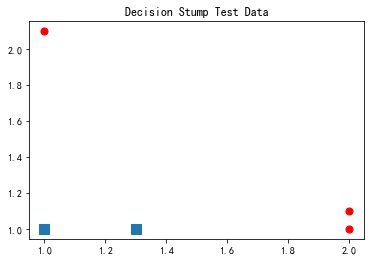

In [46]:

from numpy import* 
##### 基于单层决策树构建弱分类器
def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

# 查看数据分布
import matplotlib.pyplot as plt
def showP(datMat,classLbels):
    xcord0 = []
    ycord0 = []
    xcord1 = []
    ycord1 = []
    markers =[]
    colors =[]
    for i in range(len(classLabels)):
        if classLabels[i]==1.0:
            xcord1.append(datMat[i,0]), ycord1.append(datMat[i,1])
        else:
            xcord0.append(datMat[i,0]), ycord0.append(datMat[i,1])
    fig = plt.figure()
    ax = fig.add_subplot(111)       
    ax.scatter(xcord0,ycord0, marker='s', s=90)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
    plt.title('Decision Stump Test Data')
    plt.show()

    
dataMat,classLabels=loadSimpData()
showP(dataMat,classLabels)
    



# 建立单层决策树
### 伪代码如下：
### 用+无穷初始化最下错误率
### 对数据集中的每一个特征（第一层循环）：
     对每个步长（第二层循环）：
         对每个不等号（第三层循环）：
             建立一棵单层决策树并利用加权数据集对它进行预测
             如果错误率低于最小错误率，则将当前单层决策树设为最佳单层决策树
### 返回最佳决策树

### 该函数通过阈值比较对数据进行分类，所有在阈值一边的会分类到类别-1，而在另外一边就分类到+1
### 该函数通过数据过滤来实现

In [47]:

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    # 将返回数组所有值设为1，然后将所有满足不等式要求的元素设置为-1
    retArray = ones((shape(dataMatrix)[0],1))
    # 基于输入参数返回分类预测结果
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    # bestStump字典用于存放给定权重向量D时所得到的最佳决策树的相关信息
    # numSteps用于在特征所有可能值上进行遍历
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    # 遍历stumpClassify()函数所有可能的输入值，并找到最佳单层决策树
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        # 步长
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            # 在大于与小于之间切换不等式
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                # 分类预测结果
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                # 用于记录分类错误的相应位置
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                # 通过初始权重与错误矩阵相乘得到错误值
                weightedError = D.T*errArr  #calc total error multiplied by D
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                # 将其与最小错误率进行比较
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    # 返回字典、错误率和预测结果
    return bestStump,minError,bestClasEst

D=mat(ones((5,1))/5)
buildStump(dataMat,classLabels,D)


({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

# 完整AdaBoost实现
### 伪代码如下：
### 对于每次迭代：
     利用buildStump()函数找到最佳决策单层树
     将最佳决策单层树加入到单层决策树数组
     计算alpha
     计算新的权重向量D
     跟新累计类别估计值
     如果错误率在要求范围内（含0）推出循环



In [48]:


def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    # 设置最大迭代次数
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print("D:",D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        # 该字典包含了分类所需要的所有信息
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print("classEst: ",classEst.T)
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print("aggClassEst: ",aggClassEst.T)
        # 错误率累加计算
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        # print("total error: ",errorRate)
        # 如果错误率为0直接推出循环
        if errorRate == 0.0:
            break
    return weakClassArr


adaBoostTrainDS(dataMat,classLabels,9)

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

In [49]:
# 测试算法：基于AdaBoost的分类
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        # print(aggClassEst)
    return sign(aggClassEst)

classifierArr=adaBoostTrainDS(dataMat,classLabels,30)
# print(adaClassify([[5,5],[0,0]],classifierArr))

# 在一个难数据集上应用AdaBoost
### 搜集数据：从文本读取
### 准备数据：确保类别标签属于{-1,1}
### 分析数据：检查数据
### 训练算法：利用训练器训练出分类器
### 测试算法：对AdaBosst和逻辑回归的结果进行比较
### 使用算法：观察错误率


In [57]:


def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

dataMat,classLabels=loadDataSet(r'horseColicTraining2.txt')
# print(shape(dataMat))
testMat,testLabels=loadDataSet(r'horseColicTest2.txt')
# print(shape(testMat))
print("分类器数目    训练错误率    测试错误率")
for i in [1,10,50,100,500]:
    # 获取分类器
    classifierArr=adaBoostTrainDS(dataMat,classLabels,i)
    # 使用训练好的分类器进行训练
    trainR=adaClassify(dataMat,classifierArr)
    prediction=adaClassify(testMat,classifierArr)
    # 预测错误结果
    errorArr=mat(ones((67,1)))
    errorArr[prediction!=mat(testLabels).T].sum()
    # 训练错误结果
    errorArr1=mat(ones((299,1)))
    errorArr1[trainR!=mat(classLabels).T].sum()
    a=i
    b=errorArr1[trainR!=mat(classLabels).T].sum()/299
    c=errorArr[prediction!=mat(testLabels).T].sum()/67
    print("%d             %.2f             %.2f"%(a,b,c),end="\n")

### 从错误率中可以看出训练错误率一直在下降，但是测试错误率先下降后上升，这就是过拟合现象
### 

分类器数目    训练错误率    测试错误率
1             0.28             0.27
10             0.23             0.24
50             0.19             0.21
100             0.19             0.22
500             0.16             0.25


# 非均衡分类问题：在大多数情况下不同类别的分类代价不同
### 分类度量指标：正确率、召回率、ROC曲线
### 可以通过混淆矩阵观察分类中的错误情况
### 当某个类别重要性高于其他类别时，可以利用上述指标来进行抉择
### ROC曲线不但可以用于比较分类，还可以基于成本效益分析来做出决策
### 对于不同ROC曲线的一个比较指标就是曲线下面积，AUC，其代表分类器的平均性能值

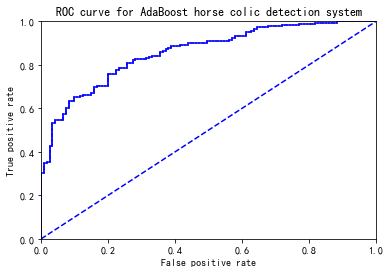

the Area Under the Curve is:  0.8582969635063604


In [58]:



def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    # 设置最大迭代次数
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print("D:",D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        # 该字典包含了分类所需要的所有信息
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print("classEst: ",classEst.T)
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print("aggClassEst: ",aggClassEst.T)
        # 错误率累加计算
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        # print("total error: ",errorRate)
        # 如果错误率为0直接推出循环
        if errorRate == 0.0:
            break
    return weakClassArr,aggClassEst

dataArr,labelArr=loadDataSet(r'horseColicTraining2.txt')
classifierArr,aggClassEst=adaBoostTrainDS(dataMat,classLabels,10)
    

# 两个参数分别为分类器预测强度、类标签
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    # ySum用于计算AUC值
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    # 获取真、假样例总数
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    # 将分类样例按照其预测强度进行排序，从排名最低的样例开始，所有排名更低的样例都被判别为反例，反则判别为正例
    # 获取排好序的索引
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    # 如果该样例为正例，对真正率进行修改，如果该样例属于反例，就对假正率进行修改
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)

plotROC(aggClassEst.T,classLabels)

# 基于代价函数的分类器决策控制
### 除了调节分类器的阈值之外，还有一些其他用于处理非均衡分类代价的方法
### 代价敏感学习：在AdaBoost中可以基于代价函数来调整错误权重向量D
### 在SVM中可以在代价函数中对于不同类别选择不同的参数C
### 在朴素贝叶斯中，可以选择具有最小期望代价而不是最大概率的类别作为最后结果


# 处理非均衡问题的数据抽样方法
### 对分类器的训练数据进行改造，可以通过欠抽样或者过抽样来实现
### 欠抽样：意味着删除样例
### 过抽样：意味着复制样例，复制已有样例或者加入已有样例相似的点，一种方法是加入已有数据点的插值点，可能会导致过拟合

# 本章小结
### 集成方法通过组合多个分类器的分类结果，获取比单分类更好的结果
### bagging是通过随机抽样的替换方式，得到了与原始数据规模一样的数据集
### boosting在bagging基础上，在数据集上顺序运用了多个不同的分类器
### 随机森林也是一种集成学习方法
### AdaBoost以弱学习器作为基分类器，并且输入数据，使其通过权重向量进行加权，第一次迭代时，所有数据都等权
### 在后续迭代中，前次迭代中错分的数据的权重会增大，针对错误进行调节
